# Tumor Diagnosis

In this project, we aim to apply data analysis, dimensionality reduction, and clustering techniques to better understand the tumor characteristics and their classification.

### 01. Import libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import time
import json
import math

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, \
    classification_report, confusion_matrix, silhouette_score
from sklearn.manifold import TSNE
from kneed import KneeLocator

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

### 02. Import data

__Class distribution:__
- __diagnosis__: Target column containing the class $labels$
  - $M$ - $Malignant$ $\rightarrow$ Tending to invade normal tissue, indicating a more harmful nature.
  - $B$ - $Benign$ $\rightarrow$ Not harmful, indicating a non-invasive and less concerning form.

__Columns in the dataset:__

0. __id__ Contains unique identifiers for each record. As a unique identifier, it cannot be used for classification purposes.
1. __radius__ Mean of distances from the center to points on the perimeter of the nucleus.
2. __texture__ Standard deviation of the gray-scale values.
3. __perimeter__ Total distance around the boundary of the nucleus.
4. __area__ Total area of the nucleus.
5. __smoothness__ Local variation in radius lengths, indicating the smoothness of the boundary.
6. __compactness__ Indicating how compact the nucleus is. (perimeter^2 / area - 1.0) 
7. __concavity__ Severity of concave portions of the contour, measuring how inward the boundary is.
8. __concave points__ Number of concave portions on the contour of the nucleus.
9. __symmetry__ Measures the symmetry of the nucleus.
10. __fractal dimension__ A measure of the "coastline approximation", calculated as the ratio of the perimeter to area.

In [3]:
# Find principal path of the project
from pathlib import Path
project_root = str(Path.cwd().parents[0])

# Load the column names from the JSON file
with open(project_root + '.\static\column_names.json', 'r') as json_file:
    saved_column_names = json.load(json_file)

# Read the .data file into a Pandas DataFrame
df = pd.read_csv(project_root + '.\static\wdbc.data', header=None, names=saved_column_names)

# Display the first few rows of the DataFrame
df.head()

,id,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Beautifully formatted output for dataset details
print(f"Data Points (Rows)   : {df.shape[0]:,}")
print(f"Features (Columns)   : {df.shape[1]}")
print(f"Feature Names        : {', '.join(df.columns)}")

Data Points (Rows)   : 569
Features (Columns)   : 32
Feature Names        : id, diagnosis, radius1, texture1, perimeter1, area1, smoothness1, compactness1, concavity1, concave_points1, symmetry1, fractal_dimension1, radius2, texture2, perimeter2, area2, smoothness2, compactness2, concavity2, concave_points2, symmetry2, fractal_dimension2, radius3, texture3, perimeter3, area3, smoothness3, compactness3, concavity3, concave_points3, symmetry3, fractal_dimension3


### 03. Data preprocesing

In this step, the unique identifier column will be removed from the dataset, as it does not contribute to the classification task. Additionally, we will perform label encoding on the $diagnosis$ column to transform the categorical labels into numerical values, making them suitable for machine learning models.

The LabelEncoder from sklearn.preprocessing will be used to convert the labels in the diagnosis column ('B' for Benign and 'M' for Malignant) to binary values (0 and 1).

In [5]:
# The 'id' column is an arbitrary identifier with no meaningful contribution 
# to pattern analysis, correlations, or clustering, and may introduce noise into the model.
df_cleaned = df.drop(columns=['id'])

In [6]:
# Creating an instance of LabelEncoder to perform label encoding
label_encoder = LabelEncoder()

# Convert 'diagnosis' column from 'b' and 'm' to 0 and 1
df_cleaned['diagnosis'] = label_encoder.fit_transform(df_cleaned['diagnosis'])

In [7]:
# See preprocessing result
df_cleaned.head()

,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 04. Correlation Analysis

The purpose of this analysis is to examine the correlation between the features in the dataset. Identifying highly correlated features is important because multicollinearity can negatively impact model performance. However, in this case, we will not remove any features, as we want to evaluate their influence on the performance of PCA (Principal Component Analysis) and clustering in later stages of the analysis.

In [8]:
# Create correlation matrix
corr_matrix = df_cleaned.corr()

In [ ]:
# Create Pairplot from Seaborn to see relationship between individual features and diagnosis
# 'Benign (0)', 'Malignant (1)'
sns.pairplot(df_cleaned, palette='coolwarm', hue='diagnosis')

# Adjust legend position to the upper left corner
plt.legend(title='Diagnosis', loc='upper left', labels=['Benign (0)', 'Malignant (1)'], fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Distribution of Features
plt.figure(figsize=(19, 17))

# Automatically get numerical columns
numerical_features = df_cleaned.select_dtypes(include=['number']).columns

# Number of rows and columns for subplots
rows = math.ceil(len(df_cleaned.columns) / 3)
cols = 3

# Adjust the figure size
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))

# Flatten the axis array for easy access
ax = ax.flatten()

# Iterate over the numerical features
for i in range(len(numerical_features)):
    sns.histplot(df_cleaned[numerical_features[i]], color='crimson', kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution: {numerical_features[i]}')

# Remove unused subplots if there are fewer features
for j in range(i + 1, rows * cols):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(19, 17))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, annot_kws={"size": 8}, fmt=".2f")
plt.show()

In [9]:
# Mask the diagonal (set to NaN) to avoid self-correlation
np.fill_diagonal(corr_matrix.values, np.nan)

# Stack the correlation matrix and sort the values
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Show the pairs with the highest correlation, excluding the diagonal
corr_pairs.head(10)

radius1     perimeter1    0.997855
perimeter1  radius1       0.997855
radius3     perimeter3    0.993708
perimeter3  radius3       0.993708
radius1     area1         0.987357
area1       radius1       0.987357
perimeter1  area1         0.986507
area1       perimeter1    0.986507
radius3     area3         0.984015
area3       radius3       0.984015
dtype: float64

### 05. Feature Engineering

Principal Component Analysis (PCA) is a dimensionality reduction technique that is particularly useful when you have many features. It reduces the number of features to a smaller set of uncorrelated features, known as principal components, while retaining as much of the original variance as possible.

- __Normalization/Standardization:__ Before applying PCA or clustering, it is crucial to scale your data, especially when features have different units or ranges. This ensures that each feature contributes equally to the analysis.

- __Domain-Specific Transformations:__ In addition to PCA, you can combine features, create new ones based on domain knowledge, or apply other feature extraction methods to improve the model’s performance.

In [10]:
# Standardizes the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)

In [11]:
# Apply PCA and keep all components
pca = PCA()
pca.fit(df_scaled)

# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Get the components (principal axes in feature space)
components = pca.components_

In [12]:
# Sum the absolute values of the components for each feature
feature_importance = np.abs(components).sum(axis=0)

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': df_cleaned.columns,
    'Importance': feature_importance
})

# Sort the features by importance (highest first)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Calculate the cumulative sum of the Importance values (each row includes the current and all previous feature importances)
feature_importance_df['Total Importance'] = feature_importance_df['Importance'].cumsum()

# Get the top 20 most important features
top_20_features = feature_importance_df.head(20)

# Print the top 20 features
top_20_features

,Feature,Importance,Total Importance
20,fractal_dimension2,4.524170,4.524170
27,concavity3,4.475811,8.999981
24,area3,4.424537,13.424518
14,area2,4.369746,17.794264
16,compactness2,4.294737,22.089001
6,compactness1,4.287754,26.376755
17,concavity2,4.285388,30.662143
26,compactness3,4.208389,34.870532
11,radius2,4.201749,39.072281
10,fractal_dimension1,4.132010,43.204291


In [13]:
# # Choose a threshold to select features (e.g., keep the top 20, or features above a certain importance)

# # Option 1: Keep the top 20 features
# top_features = top_20_features['Feature'].values
# df_reduced = df_scaled[top_features]

# # Option 2: Keep features above a certain importance threshold
# threshold = 0.1  # Set a threshold for feature importance
# important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].values
# df_reduced = df_scaled[important_features]

# # Show the reduced DataFrame with important features
# df_reduced.head()

### 06. Determine the Number of Components to Retain

To determine the optimal number of principal components to retain, we need to assess the cumulative explained variance. The goal is to retain enough components that capture a significant portion of the total variance, typically 95% or more.

1. Calculate the Explained Variance: The explained variance ratio for each component tells us the proportion of variance captured by that component.

2. Cumulative Explained Variance: By calculating the cumulative explained variance, we can visualize how much variance is captured as we add more components.

3. Plot the Cumulative Explained Variance: A plot of the cumulative explained variance helps determine the number of components required to retain a desired amount of variance.

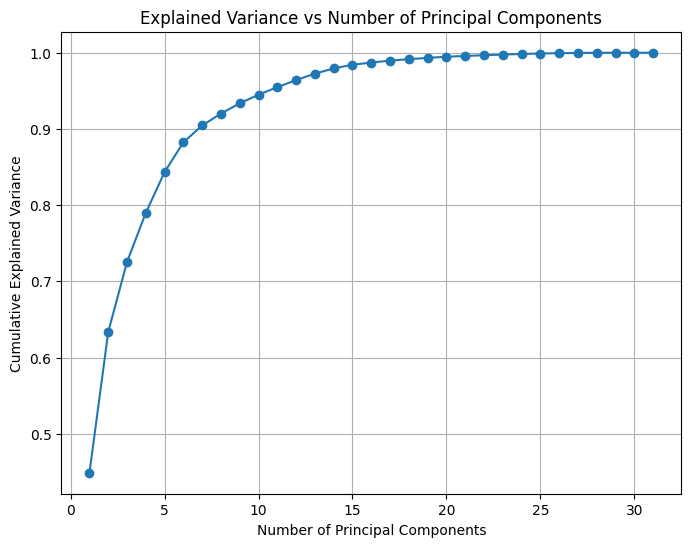

In [14]:
# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance to determine how many components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

In [15]:
# Choose the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to retain: {n_components}")

Number of components to retain: 11


In [16]:
# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

### 07. Perform Clustering on the PCA-reduced Data

- __The Elbow Method evaluates:__ the trade-off between cluster compactness (inertia) and the number of clusters. A higher _𝑘_ might better describe the structure but risks overfitting.

- __The Silhouette Method:__ evaluates how well-defined and distinct clusters are. A smaller _𝑘_ is generally more reliable in this method.

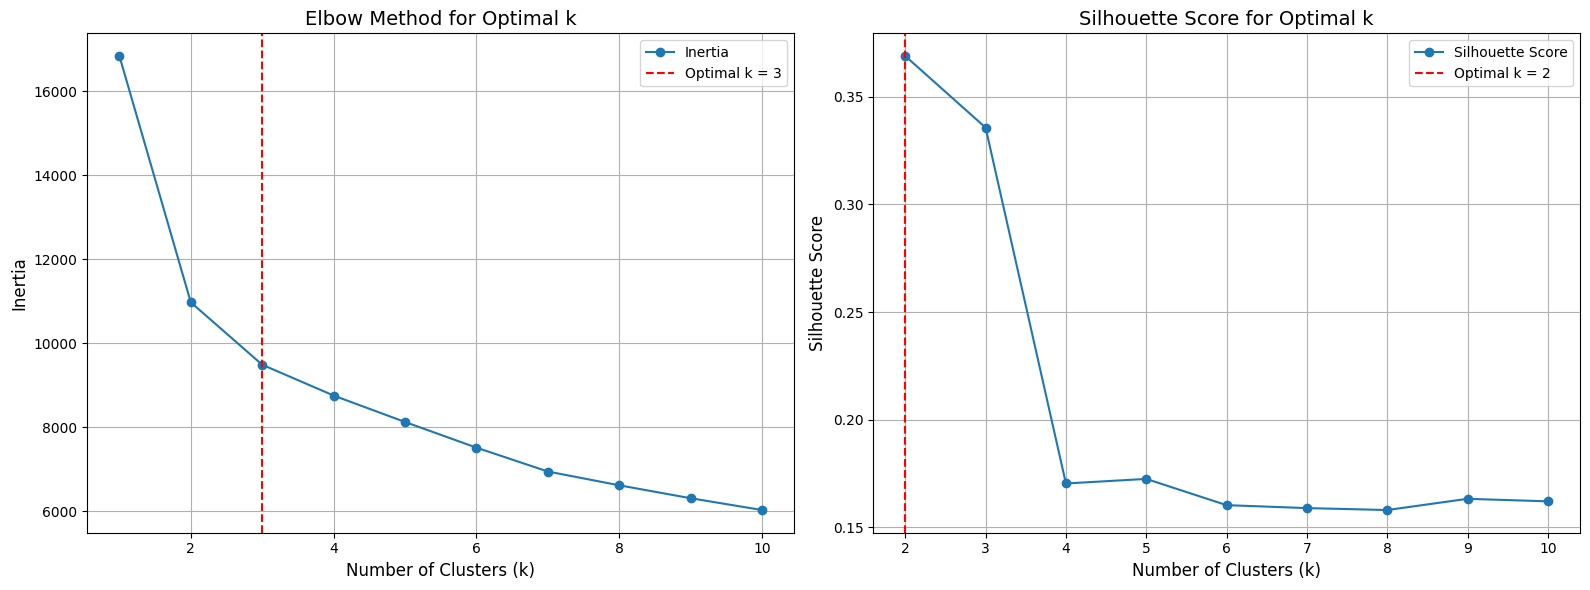

The optimal k (Elbow Method) is: 3
The optimal k (Silhouette Method) is: 2


In [17]:
# Define the range of k values
k_values_elbow = range(1, 11)
k_values_silhouette = range(2, 11)  # Silhouette requires at least 2 clusters

# Elbow Method: Calculate inertia
inertia = []
for k in k_values_elbow:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

# Automatically detect the elbow point
knee_locator = KneeLocator(k_values_elbow, inertia, curve="convex", direction="decreasing")
optimal_k_elbow = knee_locator.knee

# Silhouette Method: Calculate silhouette scores
silhouette_scores = []
for k in k_values_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the k with the maximum silhouette score
optimal_k_silhouette = k_values_silhouette[silhouette_scores.index(max(silhouette_scores))]

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Elbow Method Plot
axes[0].plot(k_values_elbow, inertia, marker='o', label='Inertia')
axes[0].axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
axes[0].set_title('Elbow Method for Optimal k', fontsize=14)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].legend()
axes[0].grid()

# Silhouette Score Plot
axes[1].plot(k_values_silhouette, silhouette_scores, marker='o', label='Silhouette Score')
axes[1].axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
axes[1].set_title('Silhouette Score for Optimal k', fontsize=14)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print(f"The optimal k (Elbow Method) is: {optimal_k_elbow}")
print(f"The optimal k (Silhouette Method) is: {optimal_k_silhouette}")

### 08. Clustering

In this step, we will examine the characteristics of each cluster and compare how the diagnoses are distributed across clusters. Additionally, we will assess whether the model was able to automatically capture and distinguish between the different diagnoses.

In [18]:
# Fit the final model
final_kmeans = KMeans(n_clusters=2, random_state=42)
final_labels = final_kmeans.fit_predict(df_pca)

In [19]:
# Add the cluster labels to the cleaned data
df_cleaned['Cluster'] = final_labels
df_cleaned.head()

,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Cluster
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


- __Cluster 0:__ Primarily consists of samples with a diagnosis of 1 (malignant or positive cases).

- __Cluster 1:__ Primarily consists of samples with a diagnosis of 0 (benign or negative cases).

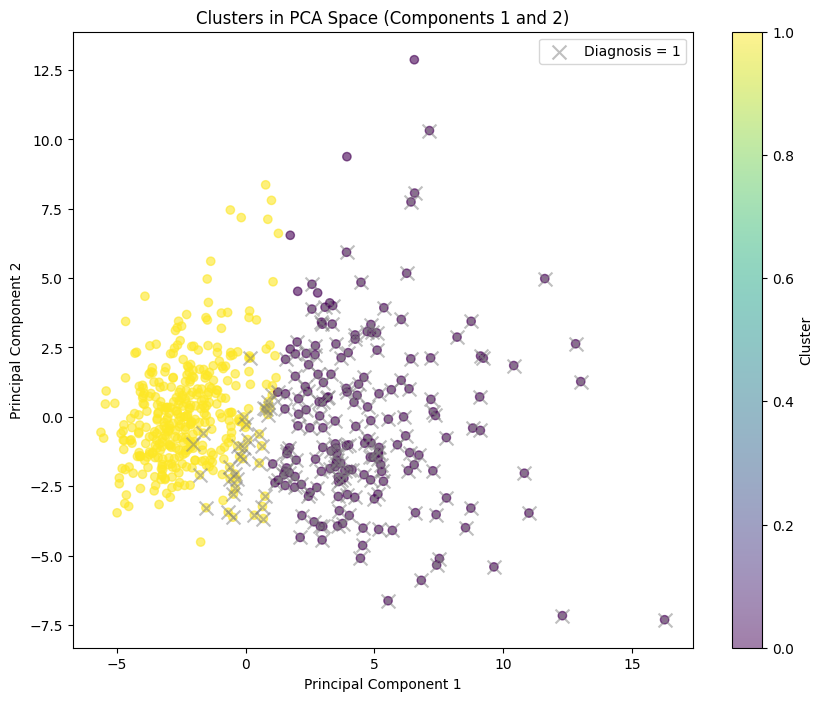

In [20]:
# Create a scatter plot using the first two principal components
plt.figure(figsize=(10, 8))

# All cluster points
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_cleaned['Cluster'], cmap='viridis', alpha=0.6)

# All diagnoses == 1, marked with an 'x'
diagnosis_1 = df_cleaned[df_cleaned['diagnosis'] == 1]
plt.scatter(df_pca[diagnosis_1.index, 0], df_pca[diagnosis_1.index, 1], color='grey', marker='x', s=100, alpha=0.5, label='Diagnosis = 1')

# Graph
plt.title('Clusters in PCA Space (Components 1 and 2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

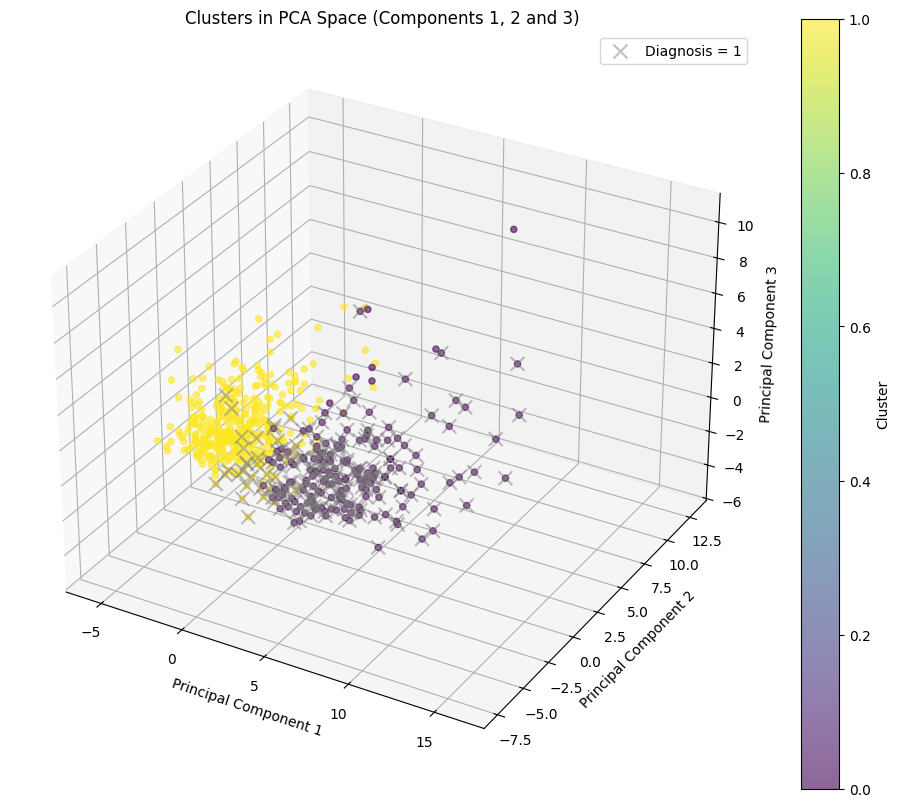

In [21]:
# Create graph in 3d
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all cluster points
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c=df_cleaned['Cluster'], cmap='viridis', alpha=0.6)

# Points with diagnosis == 1, marked with an 'x'
diagnosis_1 = df_cleaned[df_cleaned['diagnosis'] == 1]
ax.scatter(df_pca[diagnosis_1.index, 0], df_pca[diagnosis_1.index, 1], df_pca[diagnosis_1.index, 2],
           color='grey', marker='x', s=100, alpha=0.5, label='Diagnosis = 1')

# Titles and labels
ax.set_title('Clusters in PCA Space (Components 1, 2 and 3)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Color bar
fig.colorbar(scatter, ax=ax, label='Cluster')

# Legend
ax.legend()

# Show the plot
plt.show()

#### __t-SNE__
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique that enhances cluster separation in data, especially when clusters are not linearly separable. It works by minimizing the divergence between probability distributions in high-dimensional and lower-dimensional spaces. t-SNE is particularly effective for visualizing complex structures and cluster relationships that may not be clear in methods like PCA.

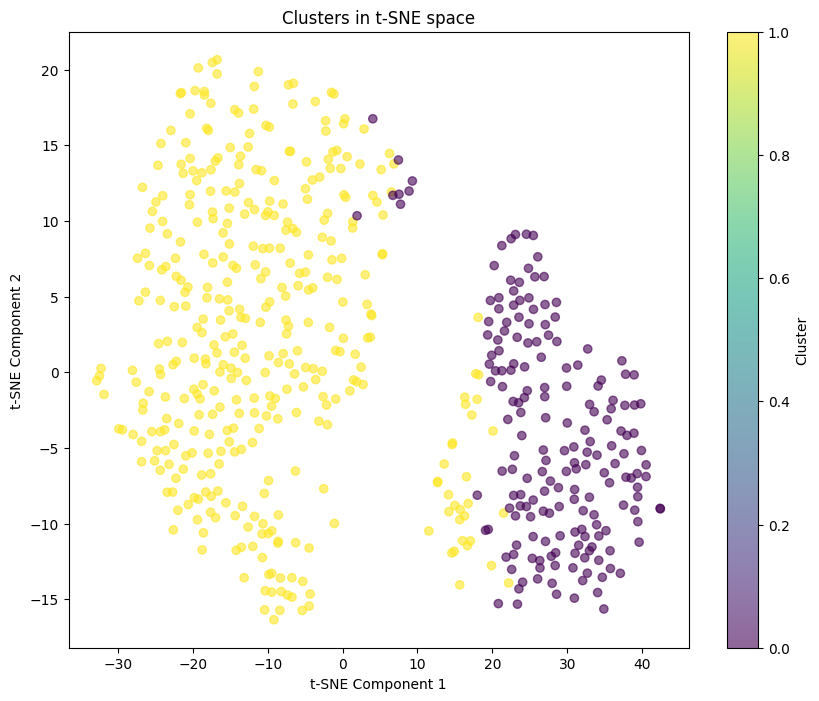

In [22]:
# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

# Plot the clusters in the 2D t-SNE space
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_cleaned['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Clusters in t-SNE space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

### 09. Model evaluation and interpretation

In [23]:
# Assign clusters to 'diagnosis' categories based on the majority
# Create a table showing the distribution of 'diagnosis' values in each cluster
cluster_diagnosis_map = df_cleaned.groupby('Cluster')['diagnosis'].agg(lambda x: x.mode()[0]).to_dict()

# Map the 'diagnosis' labels to the clusters
df_cleaned['Predicted_diagnosis'] = df_cleaned['Cluster'].map(cluster_diagnosis_map)

# Separate into two dataframes
y_true = df_cleaned['diagnosis']
y_pred = df_cleaned['Predicted_diagnosis']

In [24]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # For multiclass, use 'weighted' or 'macro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# ROC-AUC calculation requires probabilities
# Assuming you have a probability model or a function to generate predicted probabilities per class:
# Example: y_pred_prob = model.predict_proba(X_test)[:, 1]
# Replace this with your specific method of calculating probabilities
y_pred_prob = df_cleaned['Predicted_diagnosis']
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Step 3: Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
ROC-AUC: 0.91


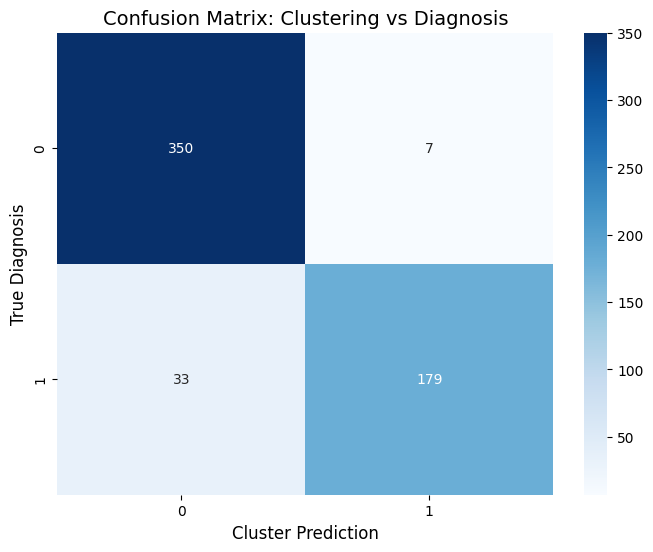

Clustering Accuracy: 92.97%


In [25]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Presenting results: Confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix: Clustering vs Diagnosis', fontsize=14)
plt.xlabel('Cluster Prediction', fontsize=12)
plt.ylabel('True Diagnosis', fontsize=12)
plt.show()

# Presenting accuracy
print(f"Clustering Accuracy: {accuracy*100:.2f}%")

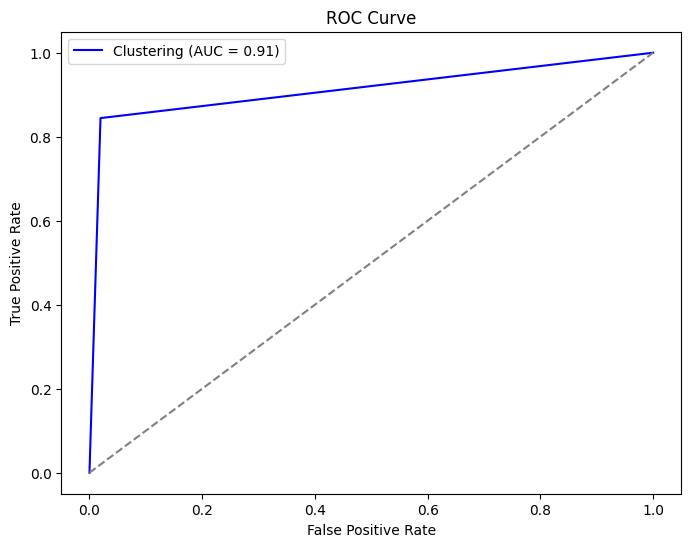

In [26]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Clustering (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

An accuracy of __92.97%__ means that the clustering model correctly predicted the diagnosis label for approximately 93% of the samples in your dataset. This indicates a high level of agreement between the clustering results and the actual diagnoses.

In summary, __false positives (FP)__ and __false negatives (FN)__ are critical in cancer diagnosis because they have direct implications on patient health and treatment. Managing these cases requires thorough review, additional testing, continuous monitoring, and refining clustering models to minimize these errors. Collaborating with medical specialists and integrating advanced diagnostic technologies are essential to improving accuracy and reducing the risks associated with diagnostic errors.

The fact that an unsupervised model like clustering achieves notable performance in a supervised context suggests that it can identify relevant underlying patterns in the data. This could uncover unknown subgroups or enhance segmentation in supervised models. However, it is crucial to validate these results with domain experts, as the clusters might not be clinically meaningful without further analysis. Clustering can complement supervised approaches, helping improve diagnostic accuracy and explore new categories within the data.

### End